In [7]:
%matplotlib inline

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import statsmodels.api as sm
from datetime import datetime as dt
from datetime import timedelta as td
from dateutil.relativedelta import relativedelta as rd

# NBER recessions
from pandas_datareader.data import DataReader


In [55]:
#pick a stock for the regime model based on users input ticker
#calculate intraday, overnight, and daily returns
def grabstock(symbol, years):
    end_date = dt.today().strftime('%Y-%m-%d')
    start_date = (dt.today() - td(days=years*365)).strftime('%Y-%m-%d')
    ticker = yf.Ticker(symbol)
    df = ticker.history(start=start_date, end=end_date)
    df['Intradayreturn'] = df.Close/df.Open-1
    overnightreturns = []
    df['overnight_return'] = (df.Open-df.Close)/df.Close
    df['daily_return'] = df['overnight_return'] + df['Intradayreturn']
    df['log_return'] = np.log(df['Close']/df['Close'].shift(1))
    df = df.dropna()
    #df['log_returns'] = log_returns
    return df

def start_regime(symbol):
    ticker = yf.Ticker(symbol)
    end_date = dt.today().strftime('%Y-%m-%d')
    start_date = (dt.today() - td(days=365)).strftime('%Y-%m-%d')
    df = ticker.history(start = start_date, end = end_date)
    df['log_return'] = np.log(df['Close']/df['Close'].shift(1))
    df = df.dropna()
    log_returns = df['log_return']
    mean = np.mean(log_returns)
    std = np.std(log_returns)
    mod_stock = sm.tsa.MarkovRegression(log_returns, k_regimes=2, switching_variance= True)
    res_stock = mod_stock.fit()
    params = res_stock.params
    if params[0] > params[1]:
        return 'bull', mean, std
    else:
        return 'bear', mean, std


def regime(symbol):
    ticker = yf.Ticker(symbol)
    df = ticker.history(period = 'max')
    first_last = df.iloc[[0, -1]]
    start_per = first_last.iloc[:,0].index[0]
    end_per = first_last.iloc[:,0].index[1]
    our_rate = first_last['Close'].iloc[-1]/first_last['Close'].iloc[0]
    #grab the SPY information for the same period
    sp500 = yf.Ticker('^GSPC')
    df2 = sp500.history(period = 'max')
    sp_per = df2.loc[(df2.index == start_per) | (df2.index == end_per)]
    sp_rate = sp_per['Close'].iloc[-1]/sp_per['Close'].iloc[0]
    #determine if stock outpaces spy over the same period of time (beats SP500)
    if our_rate >= sp_rate:
        return 0.7, 0.3, our_rate, sp_rate #bull case probabilities, following bull, bear
    else:
        return 0.3, 0.7, our_rate, sp_rate #bear case probabilities

start_regime('PEP')
#stock = grabstock('^GSPC', 4)
#regim = regime('AAPL')
#stock

c:\Users\stefa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


('bear', -0.00016236337271325387, 0.009423370887137317)

In [4]:
dta = stock
dta

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Intradayreturn,overnight_return,daily_return,log_return
Date,,,,,,,,,,,
2019-12-13 00:00:00-05:00,3166.649902,3182.679932,3156.510010,3168.800049,3757650000,0.0,0.0,0.000679,-0.000679,4.607244e-07,0.000073
2019-12-16 00:00:00-05:00,3183.629883,3197.709961,3183.629883,3191.449951,4070200000,0.0,0.0,0.002456,-0.002450,6.018808e-06,0.007122
2019-12-17 00:00:00-05:00,3195.399902,3198.219971,3191.030029,3192.520020,3842940000,0.0,0.0,-0.000901,0.000902,8.130004e-07,0.000335
2019-12-18 00:00:00-05:00,3195.209961,3198.479980,3191.139893,3191.139893,4029950000,0.0,0.0,-0.001274,0.001275,1.624644e-06,-0.000432
2019-12-19 00:00:00-05:00,3192.320068,3205.479980,3192.320068,3205.370117,3784360000,0.0,0.0,0.004088,-0.004071,1.664331e-05,0.004449
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-04 00:00:00-05:00,4564.370117,4572.370117,4546.720215,4569.779785,4369910000,0.0,0.0,0.001185,-0.001184,1.403024e-06,-0.005423
2023-12-05 00:00:00-05:00,4557.250000,4578.560059,4551.680176,4567.180176,3909950000,0.0,0.0,0.002179,-0.002174,4.737649e-06,-0.000569
2023-12-06 00:00:00-05:00,4586.229980,4590.740234,4546.500000,4549.339844,4245680000,0.0,0.0,-0.008044,0.008109,6.522534e-05,-0.003914


c:\Users\stefa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


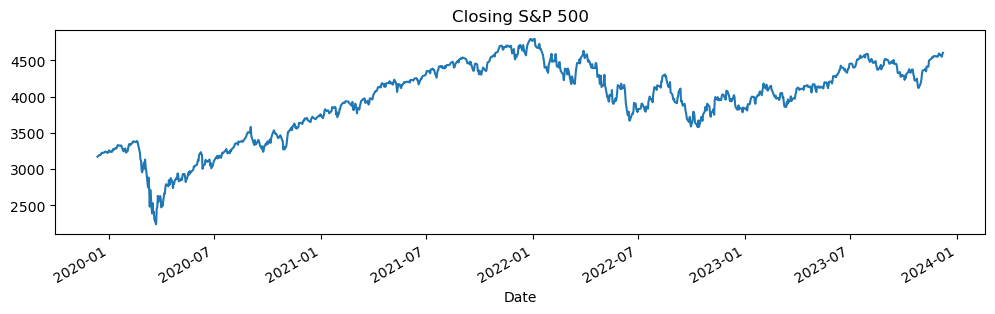

In [8]:
# Plot the data
ret = dta.Close
ret.plot(title="Closing S&P 500", figsize=(12, 3))

# Fit the model
mod_hamilton = sm.tsa.MarkovRegression(ret, k_regimes=2)
res_hamilton = mod_hamilton.fit()

In [9]:
res_hamilton.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1004
Model:               MarkovRegression   Log Likelihood               -7108.206
Date:                Mon, 11 Dec 2023   AIC                          14226.411
Time:                        18:18:27   BIC                          14250.970
Sample:                             0   HQIC                         14235.744
                               - 1004                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3248.3115     18.750    173.242      0.000    3211.562    3285.061
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4223.1695     11.099    380.512      0.000    4201.417    4244.922
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.025e+04   3590.058     22.354      0.000    7.32e+04    8.73e+04
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9953      0.004    261.941      0.000       0.988       1.003
p[1->0]        0.0023      0.002      1.364      0.173      -0.001       0.006
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

# What we can Understand from the above:

We are given two constants, in Regime Switching model regarding stock price, <br>
the most basic example is a bull regime and a bear regime:<br>

Regime 0 corresponds to the 'low' regime according to statsmodel.api references which is our bear scenario, <br>
while Regime 1 corresponds to the 'high' regime which is our bull scenario

With a mean of approx. $3243 for the market value of the S and P 500, we can assume that this is the mean of a bear market<br>
on the contrary with a mean of approx. $4218 we can say this is the mean of a bull market<br>


<Axes: title={'center': 'Probability of being in the Bull regime S&P 500'}, xlabel='Date'>

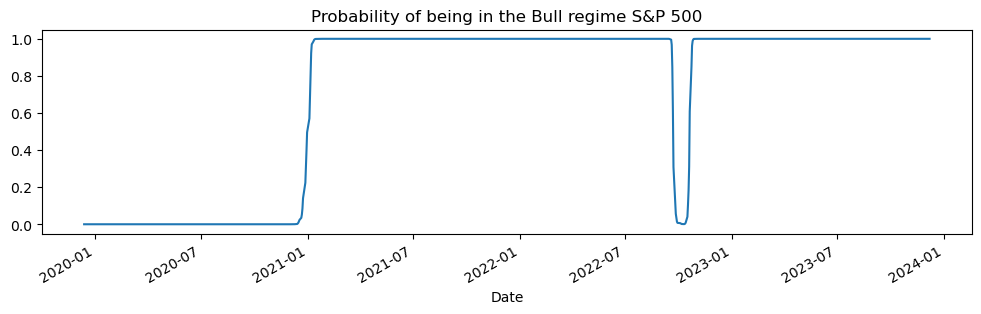

In [10]:
res_hamilton.smoothed_marginal_probabilities[1].plot(
    title="Probability of being in the Bull regime S&P 500", figsize=(12, 3)
)

### We can see that the bull periods matches what we know as the markets bull periods 

In [11]:
res_hamilton.expected_durations

array([212.75464599, 430.56706961])

##### The expected durations above returns how long we are in a bear market and bull market, respectively

We obtain this by dividing each by the number of days in a month resulting in : <br>
Approx 2 Years Bear<br>
Approx 2 Years Bull

### Changes using 3 regimes: 

Bear, Stagnant, Bull<br>


Notes:<br>
Poor visualization for market, <br>
ie market is rarely stagnant, so 3 regimes is a poor visualization

In [12]:
ret2 = dta.Close
#exog = pd.concat((dta.shift(), dta_ogap, dta_inf), axis=1).iloc[4:]
# Fit the model
mod_3 = sm.tsa.MarkovRegression(ret2, k_regimes=3)
res_3 = mod_3.fit(search_reps=20)
#print(res_3.summary())
#print(res_3.expected_durations)

c:\Users\stefa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\stefa\anaconda3\Lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1291: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have been re-scaled to continue estimation.
  warnings.warn('Invalid regime transition probabilities'
c:\Users\stefa\anaconda3\Lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1291: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have been re-scaled to continue estimation.
  warnings.warn('Invalid regime transition probabilities'


In [13]:
res_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1004
Model:               MarkovRegression   Log Likelihood               -7108.206
Date:                Mon, 11 Dec 2023   AIC                          14236.411
Time:                        18:18:41   BIC                          14285.529
Sample:                             0   HQIC                         14255.076
                               - 1004                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3217.9954      0.196   1.64e+04      0.000    3217.611    3218.379
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3248.3686     18.748    173.267      0.000    3211.624    3285.114
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4223.1261     11.098    380.545      0.000    4201.375    4244.877
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.025e+04      0.001   7.49e+07      0.000    8.02e+04    8.02e+04
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.0007     44.002    1.5e-05      1.000     -86.241      86.242
p[1->0]             0        nan        nan        nan         nan         nan
p[2->0]     1.829e-10    5.6e-05   3.26e-06      1.000      -0.000       0.000
p[0->1]        0.9993     40.743      0.025      0.980     -78.856      80.855
p[1->1]        0.9953      0.004    261.916      0.000       0.988       1.003
p[2->1]        0.0023      0.002      1.363      0.173      -0.001       0.006
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 8.45e+24. Standard errors may be unstable.
"""

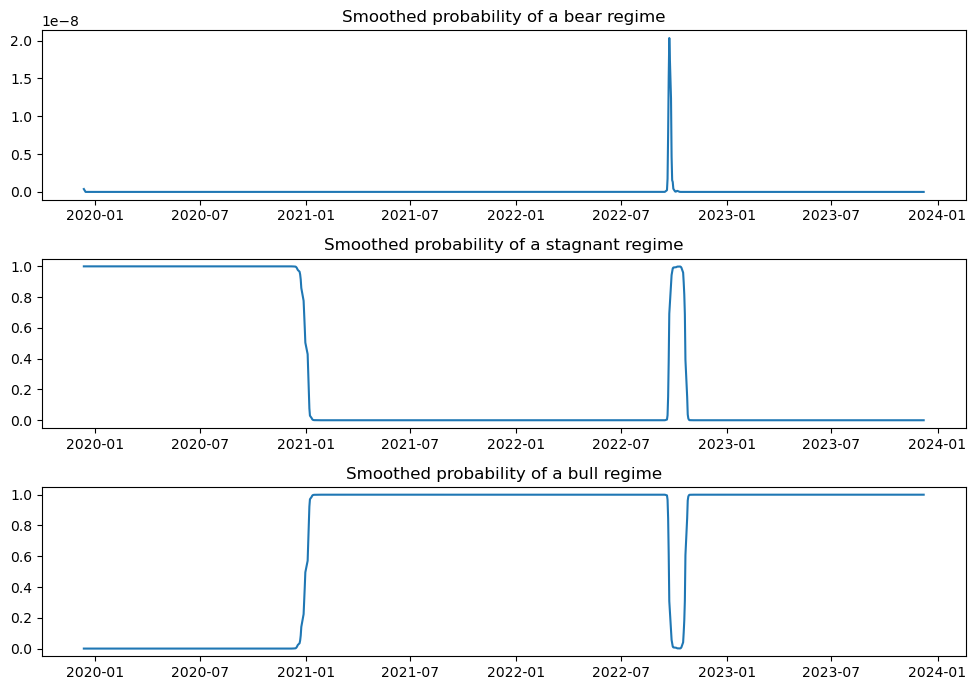

In [14]:
fig, axes = plt.subplots(3, figsize=(10, 7))

ax = axes[0]
ax.plot(res_3.smoothed_marginal_probabilities[0])
ax.set(title="Smoothed probability of a bear regime")

ax = axes[1]
ax.plot(res_3.smoothed_marginal_probabilities[1])
ax.set(title="Smoothed probability of a stagnant regime")

ax = axes[2]
ax.plot(res_3.smoothed_marginal_probabilities[2])
ax.set(title="Smoothed probability of a bull regime")

fig.tight_layout()

## Further steps: comparison to the other stocks vs market:

PEP, AAPL, GME <br>
We want to look at some cyclical stocks

In [88]:
#We use the same period as for S&P500 above: 4 years

pep = grabstock('PEP', 1)
aapl = grabstock('AAPL', 1)
atz = grabstock('CHWY', 1)

In [89]:
pep_close = pep.Close
aapl_close = aapl.Close
atz_close = atz.Close

# Fit the models
mod_pep = sm.tsa.MarkovRegression(pep_close, k_regimes=2)
res_pep = mod_pep.fit()

mod_aapl = sm.tsa.MarkovRegression(aapl_close, k_regimes=2)
res_aapl = mod_aapl.fit()

mod_atz = sm.tsa.MarkovRegression(atz_close, k_regimes=2)
res_atz = mod_atz.fit()

c:\Users\stefa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\stefa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\stefa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [90]:
res_pep.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  Close   No. Observations:                  249
Model:               MarkovRegression   Log Likelihood                -875.976
Date:                Mon, 11 Dec 2023   AIC                           1761.953
Time:                        18:42:31   BIC                           1779.540
Sample:                             0   HQIC                          1769.032
                                - 249                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        164.8627   2.92e-13   5.64e+14      0.000     164.863     164.863
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        174.8913      0.517    338.273      0.000     173.878     175.905
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        66.5582      5.965     11.158      0.000      54.867      78.250
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]     1.093e-12     82.647   1.32e-14      1.000    -161.985     161.985
p[1->0]     9.049e-21   5.58e-08   1.62e-13      1.000   -1.09e-07    1.09e-07
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 2.27e+29. Standard errors may be unstable.
"""

In [91]:
res_aapl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  Close   No. Observations:                  249
Model:               MarkovRegression   Log Likelihood                -920.956
Date:                Mon, 11 Dec 2023   AIC                           1851.911
Time:                        18:42:32   BIC                           1869.499
Sample:                             0   HQIC                          1858.991
                                - 249                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        144.1072      1.198    120.292      0.000     141.759     146.455
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        179.1401      0.742    241.478      0.000     177.686     180.594
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        91.4130      8.226     11.113      0.000      75.291     107.535
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9946      0.007    138.770      0.000       0.981       1.009
p[1->0]        0.0035      0.004      0.871      0.384      -0.004       0.011
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [92]:
res_atz.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  Close   No. Observations:                  249
Model:               MarkovRegression   Log Likelihood                -716.617
Date:                Mon, 11 Dec 2023   AIC                           1443.234
Time:                        18:42:34   BIC                           1460.821
Sample:                             0   HQIC                          1450.313
                                - 249                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.4725      0.483     42.342      0.000      19.525      21.420
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.5913      0.330    113.755      0.000      36.944      38.239
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        17.6876      1.589     11.129      0.000      14.573      20.802
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9949      0.007    149.199      0.000       0.982       1.008
p[1->0]        0.0035      0.004      0.863      0.388      -0.004       0.012
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

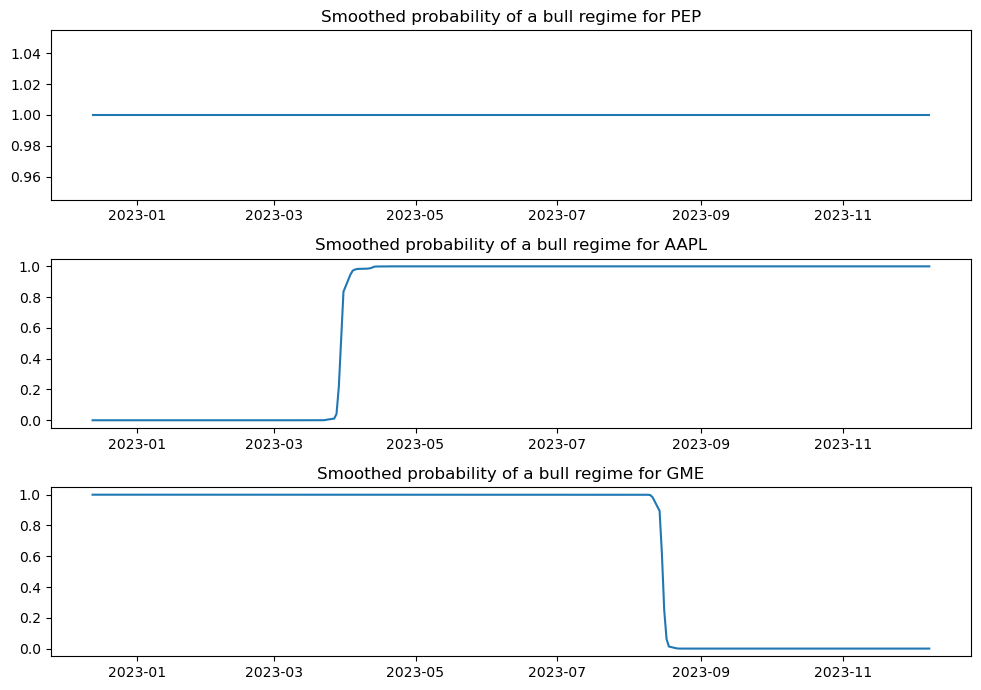

In [93]:
fig, axes = plt.subplots(3, figsize=(10, 7))

ax = axes[0]
ax.plot(res_pep.smoothed_marginal_probabilities[1])
ax.set(title="Smoothed probability of a bull regime for PEP")

ax = axes[1]
ax.plot(res_aapl.smoothed_marginal_probabilities[1])
ax.set(title="Smoothed probability of a bull regime for AAPL")

ax = axes[2]
ax.plot(res_atz.smoothed_marginal_probabilities[1])
ax.set(title="Smoothed probability of a bull regime for GME")

fig.tight_layout()

In [97]:
#Here we form markov regressions on each of the 3 stocks based on their returns
#We use the parameters as inputs for simulating the stock paths
pep_logret = pep.log_return
aapl_logret = aapl.log_return
atz_logret = atz.log_return

# Fit the models
mod_pep = sm.tsa.MarkovRegression(pep_logret, k_regimes=2)
res_pep = mod_pep.fit()

mod_aapl = sm.tsa.MarkovRegression(aapl_logret, k_regimes=2)
res_aapl = mod_aapl.fit()

mod_atz = sm.tsa.MarkovRegression(atz_logret, k_regimes=2)
res_atz = mod_atz.fit()

res_atz.params #shows calculated transition probabilities, mean, and overall var
#res_gme.params

c:\Users\stefa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\stefa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\stefa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


p[0->0]     0.498962
p[1->0]     0.499137
const[0]   -0.003328
const[1]   -0.003480
sigma2      0.001149
dtype: float64

### Simulating stock values using calculated transition probabilities and mean and volatility of each regime

In [46]:
# Initial state
#standard normal gen for both regime switch and for gbm multiply by dependent mu and vol
num_sims = 100

def simulate_regime(ticker, num_sims, initial_price, num_days, mu_bull, mu_bear, vol_bull, vol_bear, p_bear_to_bear, p_bull_to_bear):
    simulated_prices = np.zeros((num_sims, num_days))
    current_regime = start_regime(ticker)
    for i in range(num_sims):
        current_state = current_regime
        daily_returns = np.zeros(num_days)
        for day in range(num_days):
            if current_state == "bull":
                return_bull = np.random.normal(mu_bull, vol_bull)
                daily_returns[day] = return_bull

                if np.random.rand() > p_bull_to_bear:
                    current_state = "bear"
            else:
                return_bear = np.random.normal(mu_bear, vol_bear)
                daily_returns[day] = return_bear

                if np.random.rand() > p_bear_to_bear:
                    current_state = "bull"
        simulated_prices[i] = initial_price * np.cumprod(1 + daily_returns)
    return simulated_prices

In [ ]:
def gbm(ticker, num_sims, initial_price, num_days, mu_bull, mu_bear, vol_bull, vol_bear, p_bear_to_bear, p_bull_to_bear):
    simulated_prices = np.zeros((num_sims, num_days))
    current_regime = start_regime(ticker)
    for i in range(num_sims):
        current_state = current_regime
        daily_returns = np.zeros(num_days)
        for day in range(num_days):
            if current_state == "bull":
                return_bull = np.random.normal(mu_bull, vol_bull)
                daily_returns[day] = return_bull

                if np.random.rand() > p_bull_to_bear:
                    current_state = "bear"
            else:
                return_bear = np.random.normal(mu_bear, vol_bear)
                daily_returns[day] = return_bear

                if np.random.rand() > p_bear_to_bear:
                    current_state = "bull"
        simulated_prices[i] = initial_price * np.cumprod(1 + daily_returns)
    return simulated_prices

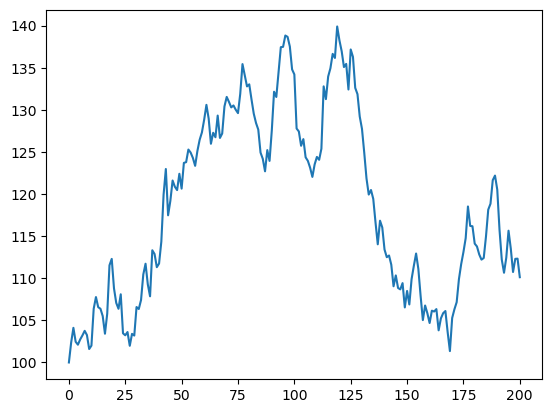

In [93]:
def gbm_stock_price(S0, mu, sigma, T, N, seed=None):
    np.random.seed(seed)
    dt = T / N
    t = np.linspace(0, T, N+1)
    W = np.random.standard_normal(size=N+1) 
    W = np.cumsum(W) * np.sqrt(dt)  # Brownian motion
    X = (0.06 - 0.5 * sigma**2) * t + sigma * W  # GBM process
    S = S0 * np.exp(X)  # Stock price process
    S[0] = S0
    return S

sim_gbm = gbm_stock_price(100, 0.1, 0.293, 1, 200)

plt.plot(sim_gbm)


In [109]:
num_sims = 100
def gbm_and_regime(ticker, num_sims, initial_price, num_days, mu_bull, mu_bear, vol_bull, vol_bear, p_bear_to_bear, p_bull_to_bear):
    #initial_price2 = initial_price
    simulated_prices = np.zeros((num_sims, num_days))
    current_regime = start_regime(ticker)
    gbm_prices = np.zeros((num_sims, num_days))
    current_state = current_regime[0] #the state, bull or bear
    #print(current_regime[1], current_regime[2])
    print(initial_price)
    for i in range(num_sims):
        #standard_normal = np.random.standard_normal()
        standard_normal = np.random.normal(current_regime[1], current_regime[2])
        print(standard_normal)
        current_state = current_regime
        daily_returns = np.zeros(num_days)
        gbm_returns = np.zeros(num_days)
        for day in range(num_days):
            gbm_returns[day] = standard_normal
            if current_state == "bull":
                return_bull = mu_bull + vol_bull*standard_normal
                daily_returns[day] = return_bull

                if np.random.rand() > p_bull_to_bear:
                    current_state = "bear"
            else:
                return_bear = mu_bear+ vol_bear*standard_normal
                daily_returns[day] = return_bear

                if np.random.rand() > p_bear_to_bear:
                    current_state = "bull"
        simulated_prices[i] = initial_price * np.cumprod(1 + daily_returns)
        gbm_prices[i] = initial_price * np.cumprod(1 + gbm_returns)
        print(gbm_prices[i][0])
    return simulated_prices

In [110]:
def stock_vals(ticker, years):
    stock = grabstock(ticker, years)
    num_days = years*252
    stock_logret = stock.log_return
    mod_stock = sm.tsa.MarkovRegression(stock_logret, k_regimes=2, switching_variance= True)
    res_stock = mod_stock.fit()
    initial_price = stock['Close'].iloc[0]
    params = res_stock.params
    print(params)
    return gbm_and_regime(ticker, num_sims, initial_price, num_days , params[2], params[3], np.sqrt(params[4]), np.sqrt(params[5]), 1-params[1], params[0])


sim_pep = stock_vals('PEP', 3)
#sim_pep
#regime = sim_pep[0]
#gbm = sim_pep[1]
#gbm



c:\Users\stefa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


p[0->0]      0.960522
p[1->0]      0.222050
const[0]     0.000736
const[1]    -0.002115
sigma2[0]    0.000072
sigma2[1]    0.000313
dtype: float64


c:\Users\stefa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


133.28248596191406
0.008057034252159407
134.35634751652213
-0.0057475134327604205
132.51644308349626
0.007837771342953036
134.32712361090387
-0.008610921346212969
132.13480095846828
-0.0002681205400079555
133.24675018980435
0.0068136863940354165
134.19063102307595
-0.008315960363444706
132.17411409151342
-0.002983633500052795
132.88481987182777
-0.014217525508882826
131.38753881786323
-0.00797830180658287
132.21911806337826
-0.019211777518537594
130.72189249449616
-0.017180404211260186
130.99263897880675
-0.0021128142679412414
133.00088482390706
-0.008697349467577093
132.12328160359587
-0.014015454656379269
131.41447132342535
-0.014974060526758997
131.28670594996345
-0.004152052258590631
132.72909011504532
-0.006162398030395298
132.46114623293616
0.00949042755878416
134.54739373979027
-0.004009851552115468
132.7480429787099
0.014339225959068955
135.19365364450837
-0.0026700961588014328
132.92660890811166
0.004957295608949853
133.94320664432297
-0.0015237504677872212
133.07939671158175


In [8]:
num_stocks = 3

mu_bull = [0]*num_stocks
mu_bear = [0]*num_stocks
vol_bull = [0]*num_stocks
vol_bear = [0]*num_stocks
p_bear_to_bear = [0]*num_stocks
p_bull_to_bear = [0]*num_stocks
#for i in range(num_stocks):
    #if i == 0:
p_bear_to_bear[0] = res_aapl.params[0]
p_bull_to_bear[0] = 1-res_aapl.params[1]
mu_bear[0] = res_aapl.params[2]
mu_bull[0] = res_aapl.params[3]
vol_bull[0] = np.sqrt(res_aapl.params[4])+np.sqrt(res_aapl.params[4])/2
vol_bear[0] = np.sqrt(res_aapl.params[4])-np.sqrt(res_aapl.params[4])/2
sim_pep = simulate(num_sims, initial_price, num_days, mu_bull[0], mu_bear[0], vol_bull[0], vol_bear[0], p_bear_to_bear[0], p_bull_to_bear[0])
print(mu_bear[0], mu_bull[0], vol_bull[0], vol_bear[0], p_bear_to_bear[0], p_bull_to_bear[0])
    #if i == 1:
       # p_bear_to_bear[i] = res_aapl.params[0]
        #p_bull_to_bear[i] = res_aapl.params[1]
        #mu_bear[i] = res_aapl.params[2]
        #mu_bull[i] = res_aapl.params[3]
        #vol_bull[i] = np.sqrt(res_aapl.params[4])+np.sqrt(res_aapl.params[4])/2
        #vol_bear[i] = np.sqrt(res_aapl.params[4])-np.sqrt(res_aapl.params[4])/2
        #sim_aapl =  simulate(num_sims, initial_price, num_days, mu_bull[i], mu_bear[i], vol_bull[i], vol_bear[i], p_bear_to_bear[i], p_bull_to_bear[i])

    #if i == 2:
        #p_bear_to_bear[i] = res_gme.params[0]
        #p_bull_to_bear[i] = res_gme.params[1]
        #mu_bear[i] = res_gme.params[2]
        #mu_bull[i] = res_gme.params[3]
        #vol_bull[i] = np.sqrt(res_gme.params[4])+np.sqrt(res_gme.params[4])/2
        #vol_bear[i] = np.sqrt(res_gme.params[4])-np.sqrt(res_gme.params[4])/2
        #sim_gme =  simulate(num_sims, initial_price, num_days, mu_bull[i], mu_bear[i], vol_bull[i], vol_bear[i], p_bear_to_bear[i], p_bull_to_bear[i])

sim_aapl = simulate(num_sims, initial_price, num_days, mu_bull[0], mu_bear[0], vol_bull[0], vol_bear[0], p_bear_to_bear[0], p_bull_to_bear[0])

sim_atz = simulate(num_sims, initial_price, num_days, mu_bull[0], mu_bear[0], vol_bull[0], vol_bear[0], p_bear_to_bear[0], p_bull_to_bear[0])




NameError: name 'res_aapl' is not defined

In [108]:
#np.cumprod(1 + daily_returns) 
#sim_aapl == sim_pep


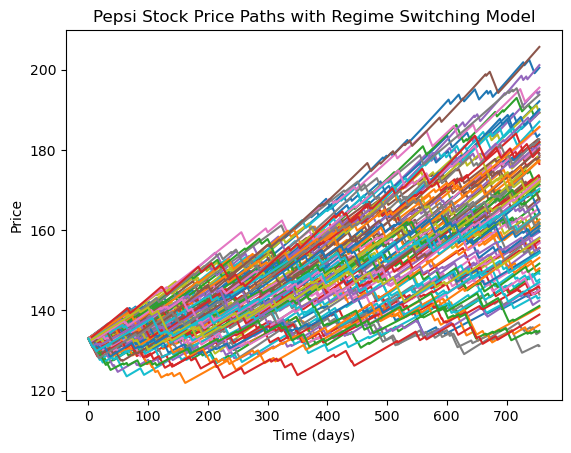

In [111]:
for i in range(100):
    plt.plot(sim_pep[i])
plt.title("Pepsi Stock Price Paths with Regime Switching Model")
plt.xlabel("Time (days)")
plt.ylabel("Price")
plt.show()

In [42]:
for i in range(100):
    plt.plot(gbm[i])
plt.title("Pepsi Stock Price Paths with Regime Switching Model")
plt.xlabel("Time (days)")
plt.ylabel("Price")
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 640x480 with 1 Axes>

In [30]:
for i in range(num_sims):
    plt.plot(sim_aapl[i])
plt.title("Apple Stock Price Paths with Regime Switching Model")
plt.xlabel("Time (days)")
plt.ylabel("Price")
plt.show()

NameError: name 'sim_aapl' is not defined

## The links for statsmodels.api:
https://www.statsmodels.org/dev/examples/notebooks/generated/markov_regression.html

https://www.statsmodels.org/stable/examples/notebooks/generated/markov_autoregression.html